<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
##ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Lab_Piecewise_Regression

# INTRODUCTION

**Piecewise regression**, extract from [Wikipedia](https://en.wikipedia.org/wiki/Segmented_regression):

Segmented regression, also known as piecewise regression or broken-stick regression, is a method in regression analysis in which the independent variable is partitioned into intervals and a separate line segment is fit to each interval. 

* Segmented regression analysis can also be performed on 
multivariate data by partitioning the various independent variables. 
* Segmented regression is useful when the independent variables, clustered into different groups, exhibit different relationships between the variables in these regions. 

* The boundaries between the segments are breakpoints.

* Segmented linear regression is segmented regression whereby the relations in the intervals are obtained by linear regression. 

## Imports

In [1]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import arviz as az
from sklearn.preprocessing import StandardScaler

In [3]:
# to plot
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D

# to generate classification, regression and clustering datasets
import sklearn.datasets as dt

# to create data frames
from pandas import DataFrame

# to generate data from an existing dataset
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [4]:
# Define the seed so that results can be reproduced
seed = 11
rand_state = 11

# Define the color maps for plots
color_map = plt.cm.get_cmap('RdYlBu')
color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","cyan","magenta","blue"])

# DATASET

## Synthetic Dataset


**Synthetic data** plays a very important role in data science, allows us to test a new algorithm under controlled conditions, we can generate data that tests a very specific property or behavior of our algorithm.

* We can test its performance on balanced vs. imbalanced datasets.
* We can evaluate its performance under different noise levels.
* We can establish a baseline of our algorithm's performance under various scenarios.

Real data may be hard or expensive to acquire, or it may have too few data-points. 

Another reason is privacy, where real data cannot be revealed to others.

### Synthetic Data for Regression

The sklearn.datasets package has functions for generating synthetic datasets for regression. 

The make_regression() function returns a set of input data points (regressors) along with their output (target). 

This function can be adjusted with the following parameters:

    n_features - number of dimensions/features of the generated data
    noise - standard deviation of gaussian noise
    n_samples - number of samples

* The response variable is a linear combination of the generated input set.

* A response variable is something that's dependent on other variables.

* In this particular case, it is a target feature that we're trying to predict using all the other input features.


### Example

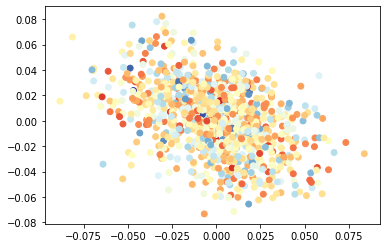

In [7]:
## Example 
# data with just 2 features
X1,y1 = dt.make_regression(n_samples=1000, n_features=2,
                        noise=50, random_state=rand_state,effective_rank=1) 

scatter_plot2 = plt.scatter(X1[:,0], X1[:,1], c=y1,
                            vmin=min(y1), vmax=max(y1),
                            s=35, cmap=color_map)


###Create Synthetic Data

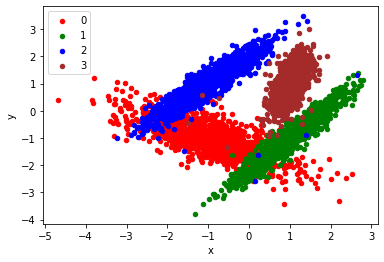

In [8]:
# create random datw with 4 clusters
from sklearn.datasets import make_classification

num_samples = 5000
X2, y2 = make_classification(n_classes=4, n_features=2, n_samples=num_samples, 
                            n_redundant=0, n_informative=2, n_clusters_per_class=1)


# create a data frame
df = DataFrame(dict(x=X2[:,0], y=X2[:,1], label=y2))
# three classes
colors = {0:'red', 1:'green', 2:'blue', 3:'brown'}
# figure
fig, ax = plt.subplots()
grouped = df.groupby('label')
# scatter plot
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
# show the plot
plt.show()

In [9]:
## Main dataset with 4 features
# we'll use this dataset

X3,y3 = dt.make_regression(n_samples=num_samples, n_features=4, n_informative=4,
                        noise=.2, random_state=rand_state) 

In [10]:
# intervals to scale features
scaleX0 = (50, 60)
scaleX1 = (4, 7)
scaleX2 = (1, 2)
scaleX3 = (450, 710)
scaleX4 = (30, 5000)
scaleX5 = (10, 800)
scaleY = (150000, 2000000)

# Scale features
f0 = np.interp(X2[:,0], (X2[:,0].min(), X2[:,0].max()), scaleX0)
f1 = np.interp(X2[:,1], (X2[:,1].min(), X2[:,1].max()), scaleX1)
f2 = np.interp(X3[:,0], (X3[:,0].min(), X3[:,0].max()), scaleX2)
f3 = np.interp(X3[:,1], (X3[:,1].min(), X3[:,1].max()), scaleX3)
f4 = np.interp(X3[:,2], (X3[:,2].min(), X3[:,2].max()), scaleX4)
f5 = np.interp(X3[:,3], (X3[:,3].min(), X3[:,3].max()), scaleX5)

# scaled data
X = np.stack((f0,f1,f2,f3,f4,f5), axis=1)
y = np.interp(y3, (y3.min(), y3.max()), scaleY)

## Training & Test Data

In [11]:
# split data into training and test
from sklearn.model_selection import train_test_split

# training: 70% (0.7), test: 30% (0.3)
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3)

In [12]:
def replace_with_nan(df,frac):
  """Replace some values randomly with nan"""
  # requires numpy & pandas
  rows = np.random.choice(range(df.shape[0]), int(df.shape[0]*frac), replace=False)
  cols = np.random.choice(range(0,df.shape[1]-1), size=len(rows), replace=True)
  to_repl = [np.nan for i, col in zip(rows, cols)] 
  # method used to cast a pandas object to a specified dtype
  rnan = df.astype(object).to_numpy()
  rnan[rows, cols] = to_repl
  # returns data frame with nans
  return DataFrame(rnan, index=df.index, columns=df.columns)

### Train dataset

In [13]:
## create train data frame
# use meaningful names
dftrain = DataFrame(dict(feature_1=X_train[:,0], 
                    feature_2=X_train[:,1],
                    feature_3=X_train[:,2], 
                    feature_4=X_train[:,3],
                    feature_5=X_train[:,4],
                    feature_6=X_train[:,5],
                    cost=y_train))

In [14]:
# dftrain with nans
dftrain = replace_with_nan(dftrain,.10)
print('Number of nan in train dataset: ',dftrain.isnull().sum().sum())

Number of nan in train dataset:  350


In [15]:
# show first data frame rows 
dftrain.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,cost
0,58.4675,5.45386,1.63121,612.772,2296.7,427.373,1.27271e+06
1,55.0484,6.02366,1.59265,594.488,2036.19,340.479,1.07257e+06
2,58.1689,6.41836,1.56636,558.773,2525.06,563.409,1.21748e+06
3,55.3789,6.12732,1.66818,531.179,2436.06,407.698,1.14854e+06
4,55.9038,6.21563,1.57562,504.647,1917.26,67.3516,632950


In [16]:
# Generate descriptive statistics
dftrain.describe()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,cost
count,3440.000000,3435.000000,3448.000000,3434.0000,3448.000000,3445.000000,3500.000000
unique,3440.000000,3435.000000,3448.000000,3434.0000,3448.000000,3445.000000,3500.000000
top,58.731999,5.649673,1.522796,572.9387,1944.092964,384.115948,816785.517741
freq,1.000000,1.000000,1.000000,1.0000,1.000000,1.000000,1.000000


### Test dataset

In [17]:
## create test data frame
# no cost included

dftest = DataFrame(dict(feature_1=X_test[:,0], 
                    feature_2=X_test[:,1],
                    feature_3=X_test[:,2], 
                    feature_4=X_test[:,3],
                    feature_5=X_test[:,4],
                    feature_6=X_test[:,5]))

In [18]:
# dftrain with nans
dftest = replace_with_nan(dftest,.10)
print('Number of nan in test dataset: ',dftest.isnull().sum().sum())

Number of nan in test dataset:  150


In [19]:
# show first data frame rows 
dftest.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6
0,55.4025,6.09604,1.59118,576.115,2881.56,257.29
1,58.6274,5.56615,1.45622,599.009,2668.24,483.495
2,55.1885,6.08833,1.48083,527.852,3589.56,410.061
3,55.3182,6.01653,1.59787,554.692,1058.6,249.404
4,57.6123,5.71384,1.62144,572.698,2417.52,398.986


In [20]:
# Generate descriptive statistics
dftest.describe()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6
count,1469.00000,1468.000000,1468.000000,1472.000000,1473.000000,1500.000000
unique,1469.00000,1468.000000,1468.000000,1472.000000,1473.000000,1500.000000
top,57.59012,6.240452,1.537171,511.997094,2047.266696,511.323188
freq,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


### Expected Cost dataset

In [21]:
## create expected cost data frame
# the cost is in another file
dfcost = DataFrame(dict(cost=y_test))
# show first data frame rows 
dfcost.head()

,cost
0,1.134324e+06
1,1.144482e+06
2,1.142367e+06
3,7.352482e+05
4,1.174690e+06


In [22]:
# Generate descriptive statistics
dfcost.describe()

,cost
count,1.500000e+03
mean,1.059876e+06
std,2.355347e+05
min,1.500000e+05
25%,9.009446e+05
50%,1.062837e+06
75%,1.222795e+06
max,1.786696e+06


## Save dataset

You can save your datataset in any location suitable for you, one choice using Colab is to save it in your Google Drive this way you will have it handy for your experiments.

In [23]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
# path to your Google Drive
pathDrive = '/content/drive/MyDrive/Colab Notebooks/Enrique/Data/'

In [25]:
#  create a directory (if not exist)
import os

folderName = 'SyntData/'
syntPath = pathDrive+folderName

if os.path.exists(syntPath):
  print(folderName,' directory already exists')
else:
  # create a directory
  os.mkdir(syntPath)
  print('Now you have a new directory: ',folderName)

SyntData/  directory already exists


In [26]:
# manage versions if you like to save more datasets
# syntTrain1.csv, syntTrain2.csv, etc

## save train dataset into your Drive
filename1 = 'syntTrain.csv'
dftrain.to_csv(syntPath+filename1, encoding='utf-8', index=False)

# save test dataset into your Drive
filename2 = 'syntTest.csv'
dftest.to_csv(syntPath+filename2, encoding='utf-8', index=False)

# save cost dataset into your Drive
filename3 = 'syntCost.csv'
dfcost.to_csv(syntPath+filename3, encoding='utf-8', index=False)

## Load your dataset

In [27]:
# training dataset: 
training_file = syntPath+filename1
# test dataset: 
testing_file = syntPath+filename2
# cost dataset: 
cost_file = syntPath+filename3

In [28]:
# load train dataset
df_train = pd.read_csv(training_file)
df_train.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,cost
0,58.467508,5.453856,1.631212,612.772281,2296.702922,427.373281,1.272714e+06
1,55.048413,6.023656,1.592648,594.487899,2036.187662,340.478711,1.072565e+06
2,58.168889,6.418361,1.566364,558.772884,2525.062099,563.409328,1.217476e+06
3,55.378865,6.127323,1.668185,531.178939,2436.055511,407.697588,1.148538e+06
4,55.903844,6.215628,1.575621,504.647374,1917.262937,67.351581,6.329503e+05


In [29]:
# load test dataset
df_test = pd.read_csv(testing_file)
df_test.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6
0,55.402476,6.096039,1.591177,576.114849,2881.560565,257.290141
1,58.627361,5.566149,1.456222,599.009485,2668.240262,483.495167
2,55.188484,6.088331,1.480830,527.851707,3589.559737,410.060829
3,55.318189,6.016529,1.597871,554.691656,1058.599070,249.403770
4,57.612268,5.713838,1.621436,572.698403,2417.518238,398.986229


In [30]:
# load cost dataset
df_cost = pd.read_csv(cost_file)
df_cost.head()

,cost
0,1.134324e+06
1,1.144482e+06
2,1.142367e+06
3,7.352482e+05
4,1.174690e+06


# PIECEWISE REGRESSION

## Full Model

In [31]:
# select some features columns just for the baseline model
# assume not all of the features are informative or useful
# in this exercise you could try all of them

featrain = ['feature_1','feature_2','feature_3','cost']
# dropna: remove missing values
df_subset_train = dftrain[featrain].dropna(axis=0)

featest = ['feature_1','feature_2','feature_3']
df_subset_test  =  dftest[featest].dropna(axis=0)

# cost
df_cost = df_cost[df_cost.index.isin(df_subset_test.index)]

In [32]:
print('Number of nan in df_subset_train dataset: ',df_subset_train.isnull().sum().sum())
print('Number of nan in df_subset_test dataset: ',df_subset_test.isnull().sum().sum())

Number of nan in df_subset_train dataset:  0
Number of nan in df_subset_test dataset:  0


In [33]:
# train set, input columns
Xs_train = df_subset_train.iloc[:,0:-1].values 
# train set, output column, cost
ys_train = df_subset_train.iloc[:,-1].values.reshape(-1,1)   

# test set, input columns
Xs_test = df_subset_test.iloc[:,0:].values 
# test set, output column, cost
y_test = df_cost.cost.values

In [34]:
# StandardScaler() will normalize the features i.e. each column of X, 
# so, each column/feature/variable will have μ = 0 and σ = 1
sc = StandardScaler()

Xss_train = np.hstack([Xs_train,Xs_train[:,[2]]**2])
xscaler = sc.fit(Xss_train)
Xn_train = xscaler.transform(Xss_train)

Xss_test = np.hstack([Xs_test,Xs_test[:,[2]]**2])
Xn_test = xscaler.transform(Xss_test)

ylog = np.log(ys_train.astype('float'))
yscaler = StandardScaler().fit(ylog)
yn_train = yscaler.transform(ylog)

In [35]:
# model
with pm.Model() as model:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    #we have one beta for each column of Xn
    beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn_train.shape[1])
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
    #linear regression model in matrix form
    mu = alpha + pm.math.dot(beta, Xn_train.T)
    #likelihood, be sure that observed is a 1d vector
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn_train[:,0])
    

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Finished [100%]: Average Loss = 3,868.4


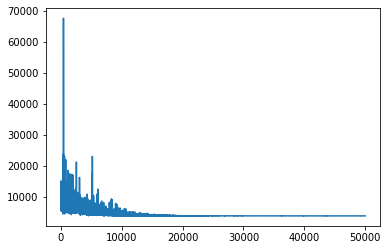

In [36]:
#number of iterations of the algorithms
iter = 50000 

# run the model
with model:
    approximation = pm.fit(iter,method='advi')
    
# check the convergence
plt.plot(approximation.hist);

In [37]:
# samples from the posterior
posterior = approximation.sample(5000)

In [38]:
# prediction
ll=np.mean(posterior['alpha']) + np.dot(np.mean(posterior['beta'],axis=0), Xn_test.T)
y_pred_BLR = np.exp(yscaler.inverse_transform(ll.reshape(-1,1)))[:,0]
print("MAE = ",(np.mean(abs(y_pred_BLR - y_test))))
print("MAPE = ",(np.mean(abs(y_pred_BLR - y_test) / y_test)))

MAE =  141328.74408589717
MAPE =  0.14469413052199676


## Clustering

### Full Model

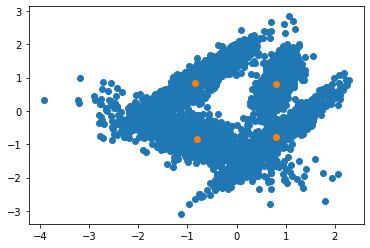

In [39]:
# training gaussian mixture model 
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4)
# clustering by features 1, 2
ind=[0,1]
X_ind = np.vstack([Xn_train[:,ind],Xn_test[:,ind]])
# Gaussian Mixture
gmm.fit(X_ind)
# plot blue dots
plt.scatter(X_ind[:,0],X_ind[:,1])
# centroids:  orange dots
plt.scatter(gmm.means_[:,0],gmm.means_[:,1])

In [40]:
np.max(ys_train)

2000000.0

### Clusters

In [41]:
# train clusters
clusters_train = gmm.predict(Xn_train[:,ind])
unique_train, counts_train = np.unique(clusters_train, return_counts=True)
dict(zip(unique_train, counts_train))


{0: 821, 1: 849, 2: 870, 3: 783}

In [42]:
# test clusters
clusters_test = gmm.predict(Xn_test[:,ind])
unique_test, counts_test = np.unique(clusters_test, return_counts=True)
dict(zip(unique_test, counts_test))

{0: 328, 1: 331, 2: 379, 3: 367}

In [43]:
# cluster 0
Xn0 = Xn_train[clusters_train==0,:]
Xtestn0 = Xn_test[clusters_test==0,:]

ylog0 = np.log(ys_train.astype('float')[clusters_train==0,:])
yscaler0 = StandardScaler().fit(ylog0)
yn0 = yscaler0.transform(ylog0)


In [44]:
# cluster 1
Xn1 = Xn_train[clusters_train==1,:]
Xtestn1 = Xn_test[clusters_test==1,:]
ylog1 = np.log(ys_train.astype('float')[clusters_train==1,:])
yscaler1 = StandardScaler().fit(ylog1)
yn1 = yscaler1.transform(ylog1)

In [45]:
# cluster 2
Xn2 = Xn_train[clusters_train==2,:]
Xtestn2 = Xn_test[clusters_test==2,:]
ylog2 = np.log(ys_train.astype('float')[clusters_train==2,:])
yscaler2 = StandardScaler().fit(ylog2)
yn2 = yscaler2.transform(ylog2)


In [46]:
# cluster 3
Xn3 = Xn_train[clusters_train==3,:]
Xtestn3 = Xn_test[clusters_test==3,:]
ylog3 = np.log(ys_train.astype('float')[clusters_train==3,:])
yscaler3 = StandardScaler().fit(ylog3)
yn3 = yscaler3.transform(ylog3)

## Piecewise Model

In [47]:
# model_0
with pm.Model() as model_0:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn0
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn0.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn0.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn0[:,0])

with model_0:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior   
posterior0 = approximation.sample(5000)

Finished [100%]: Average Loss = 1,003.8


In [48]:
# model_1
with pm.Model() as model_1:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn1.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn1.T)
  # likelihood, # 
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn1[:,0])
  
with model_1:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior    
posterior1 = approximation.sample(5000)

Finished [100%]: Average Loss = 1,004.3


In [49]:
# model_2
with pm.Model() as model_2:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn2.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  # linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn2.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn2[:,0])
    
with model_2:
  # iterations of the algorithms
  approximation = pm.fit(40000,method='advi')

# samples from the posterior    
posterior2 = approximation.sample(5000)

Finished [100%]: Average Loss = 1,032.6


In [50]:
# model_3
with pm.Model() as model3:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn3.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  mu = alpha + pm.math.dot(beta, Xn3.T)#linear regression model in matrix form
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn3[:,0])
    
with model3:
  # number of iterations of the algorithms
  approximation = pm.fit(40000,method='advi')

# samples from the posterior     
posterior3 = approximation.sample(5000)

Finished [100%]: Average Loss = 943.02


In [51]:
#############

In [52]:
# Posterior predictive checks (PPCs)
def ppc(alpha,beta,sigma, X,  nsamples=500):
    #we select nsamples random samples from the posterior
    ind = np.random.randint(0,beta.shape[0],size=nsamples)
    alphai = alpha[ind]
    betai = beta[ind,:]
    sigmai = sigma[ind]

    Ypred = np.zeros((nsamples,X.shape[0]))
    for i in range(X.shape[0]):
        #we generate data from linear model
        y_pred = alphai + np.dot(betai, X[i:i+1,:].T).T +np.random.randn(len(sigmai))*sigmai
        Ypred[:,i]=y_pred[0,:]
    return Ypred



##Simulations

### Only Cluster 0

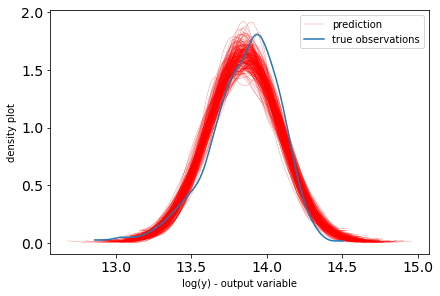

In [53]:
#Simulation
Ypred0 = yscaler0.inverse_transform(ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xn0,  nsamples=200))
for i in range(Ypred0.shape[0]):
    az.plot_dist( Ypred0[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred0[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog0,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

### Only Cluster 1

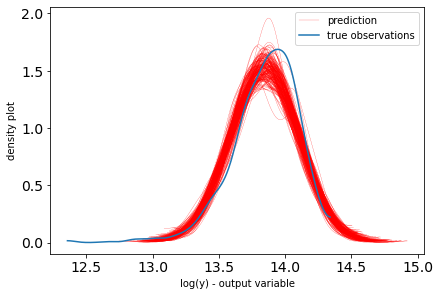

In [54]:
#Simulation
Ypred1 = yscaler1.inverse_transform(ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xn1,  nsamples=200))
for i in range(Ypred1.shape[0]):
    az.plot_dist( Ypred1[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred1[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog1,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

### Only Cluster 2

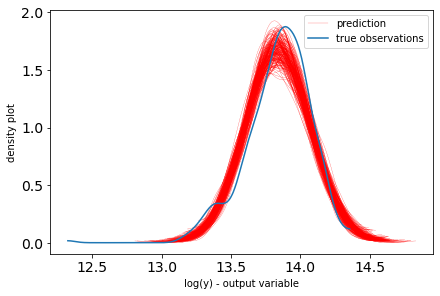

In [55]:
#Simulation
Ypred2 = yscaler2.inverse_transform(ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xn2,  nsamples=200))
for i in range(Ypred2.shape[0]):
    az.plot_dist( Ypred2[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred2[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog2,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

### Only Cluster 3

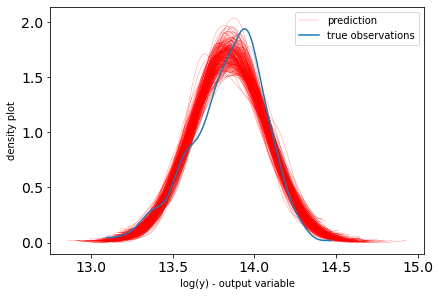

In [56]:
#Simulation
Ypred3 = yscaler3.inverse_transform(ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xn3,  nsamples=200))
for i in range(Ypred3.shape[0]):
    az.plot_dist( Ypred3[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred3[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog3,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

## Overall

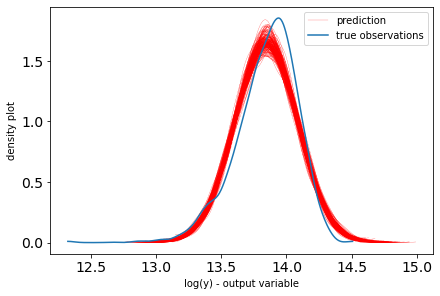

In [57]:
# posteriors
Ypred0 = ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xn0,  nsamples=200)
Ypred1 = ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xn1,  nsamples=200)
Ypred2 = ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xn2,  nsamples=200)
Ypred3 = ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xn3,  nsamples=200)

# simulation
Ypred = np.hstack([ yscaler0.inverse_transform(Ypred0),
                 yscaler1.inverse_transform(Ypred1),
                 yscaler2.inverse_transform(Ypred2),
                 yscaler3.inverse_transform(Ypred3)])

# prediction
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})

# plot
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
ylog=np.vstack([ylog0,ylog1,ylog2,ylog3])
az.plot_dist(ylog,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

## Test set performance

In [59]:
# cluster 0
y_pred_BLR0 = np.exp(yscaler0.inverse_transform(np.mean(posterior0['alpha']) 
              + np.dot(np.mean(posterior0['beta'],axis=0), Xtestn0.T)))
print("Size Cluster0", np.sum(clusters_test==0), ", MAE Cluster0=",
      (np.mean(abs(y_pred_BLR0 - y_test[clusters_test==0]))))

# cluster 1
y_pred_BLR1 = np.exp(yscaler1.inverse_transform(np.mean(posterior1['alpha']) 
              + np.dot(np.mean(posterior1['beta'],axis=0), Xtestn1.T)))
print("Size Cluster1", np.sum(clusters_test==1), ", MAE Cluster1=",
      (np.mean(abs(y_pred_BLR1 - y_test[clusters_test==1]))))

# cluster 2
y_pred_BLR2 = np.exp(yscaler2.inverse_transform(np.mean(posterior2['alpha']) 
              + np.dot(np.mean(posterior2['beta'],axis=0), Xtestn2.T)))
print("Size Cluster2", np.sum(clusters_test==2), ", MAE Cluster2=",
      (np.mean(abs(y_pred_BLR2 - y_test[clusters_test==2]))))

# cluster 3
y_pred_BLR3 = np.exp(yscaler3.inverse_transform(np.mean(posterior3['alpha']) 
              + np.dot(np.mean(posterior3['beta'],axis=0), Xtestn3.T)))
print("Size Cluster3", np.sum(clusters_test==3), ", MAE Cluster3=",
      (np.mean(abs(y_pred_BLR3 - y_test[clusters_test==3]))))

# joint
joint=np.hstack([abs(y_pred_BLR0 - y_test[clusters_test==0]),
                 abs(y_pred_BLR1 - y_test[clusters_test==1]),
                 abs(y_pred_BLR2 - y_test[clusters_test==2]),
                 abs(y_pred_BLR3 - y_test[clusters_test==3])])

# MAE
print("MAE=",np.mean(joint))

Size Cluster0 328 , MAE Cluster0= 140400.05311803642
Size Cluster1 331 , MAE Cluster1= 133788.93120288427
Size Cluster2 379 , MAE Cluster2= 138797.9859075452
Size Cluster3 367 , MAE Cluster3= 154811.29969757976
MAE= 142174.75964330396


### PPC on the Test set



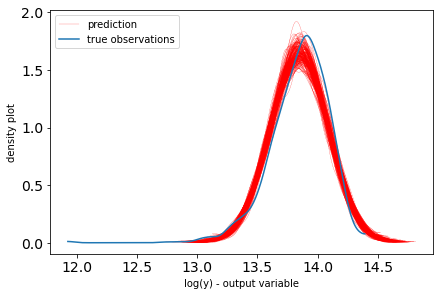

In [60]:
## Posterior predictive checks (PPCs)

num_samples2 = 200
Ypred0 = ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xtestn0, nsamples=num_samples2)
Ypred1 = ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xtestn1, nsamples=num_samples2)
Ypred2 = ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xtestn2, nsamples=num_samples2)
Ypred3 = ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xtestn3, nsamples=num_samples2)

# Stack arrays in sequence horizontally (column wise)
Ypred = np.hstack([yscaler0.inverse_transform(Ypred0),
                 yscaler1.inverse_transform(Ypred1),
                 yscaler2.inverse_transform(Ypred2),
                 yscaler3.inverse_transform(Ypred3)])

# plot prediction shape
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})
# label
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")

# true observations
az.plot_dist(np.log(y_test),label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");